In [ ]:
%pip install underthesea

In [1]:
import re, math, requests, os
import pandas as pd, numpy as np
from collections import Counter, defaultdict

from underthesea import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [2]:
STOPWORDS_URL = "https://raw.githubusercontent.com/stopwords-iso/stopwords-vi/master/stopwords-vi.txt"
try:
    stopwords = set(requests.get(STOPWORDS_URL, timeout=10).text.splitlines())
except Exception:
    stopwords = set()


df = pd.read_json("corpus.jsonl", lines=True)

for col in ["title", "content", "source"]:
    if col not in df.columns:
        df[col] = ""

if "text" not in df.columns:
    df["text"] = (df["title"].fillna("") + " " + df["content"].fillna(""))

df = df.fillna("")

In [3]:
def vi_tokenize(text: str) -> str:
    text = text.lower()
    text = re.sub(r"https?://\S+", " ", text)
    text = re.sub(r"[0-9]+", " ", text)
    text = re.sub(
        r"[^a-zàáạảãâăằắặẳẵấầậẩẫèéẹẻẽêềếệểễ"
        r"ìíịỉĩòóọỏõôồốộổỗơờớợởỡùúụủũưừứựửữ"
        r"ỳýỵỷỹđ\s]", " ", text
    )
    text = re.sub(r"\s+", " ", text).strip()
    return word_tokenize(text, format="text") if text else ""

if "norm" not in df.columns:
    df["norm"] = df["text"].apply(vi_tokenize)
else:
    df["norm"] = df["norm"].replace({None: ""}).astype(str)

In [4]:
word_freq = Counter()
bigram_freq = Counter()
total_tokens = 0

for doc in df["norm"]:
    toks = doc.split()
    total_tokens += len(toks)
    word_freq.update(toks)
    bigram_freq.update(zip(toks, toks[1:]))

def pmi(bg):
    w1, w2 = bg
    pxy = bigram_freq[bg] / max(total_tokens, 1)
    px  = word_freq[w1] / max(total_tokens, 1)
    py  = word_freq[w2] / max(total_tokens, 1)
    return math.log2((pxy / (px * py + 1e-9)) + 1e-9)

phrase_scores = sorted(
    [(" ".join(bg), pmi(bg)) for bg in bigram_freq if bigram_freq[bg] >= 3],
    key=lambda x: x[1],
    reverse=True
)
TOP_PHRASES = [p for p, _ in phrase_scores[:200]]

def merge_phrases(doc: str) -> str:
    out = doc
    for p in TOP_PHRASES:
        out = out.replace(p, p.replace(" ", "_"))
    return out

if "norm_phrase" not in df.columns:
    df["norm_phrase"] = df["norm"].apply(merge_phrases)

In [5]:
def analyzer(doc: str):
    toks = doc.split()
    cleaned = []
    for t in toks:
        if "_" in t:
            cleaned.append(t)
        elif len(t) > 2 and t not in stopwords:
            cleaned.append(t)
    return cleaned

vectorizer = TfidfVectorizer(
    analyzer=analyzer,
    ngram_range=(1, 2),
    min_df=3,
    max_df=0.65,
    max_features=15000
)

corpus = df["norm_phrase"].fillna("").tolist()
if not any(corpus):
    raise ValueError("Corpus rỗng sau khi tiền xử lý. Kiểm tra dữ liệu đầu vào.")

X = vectorizer.fit_transform(corpus)
terms = vectorizer.get_feature_names_out()

c:\Users\Anh Kiet\anaconda3\envs\Automobile\Lib\site-packages\sklearn\feature_extraction\text.py:533: UserWarning: The parameter 'ngram_range' will not be used since 'analyzer' is callable'
  warnings.warn(


In [6]:
domain_weight = {
    "vinmec": 1.0, "tudu": 1.0, "cdc.gov": 1.0, "nhs.uk": 1.0,
    "suckhoedoisong": 0.9, "hellobacsi": 0.9, "benhvienphuongdong": 0.9, "viendinhduong": 0.9,
    "marrybaby": 0.85, "kidsplaza": 0.85, "kidshealth": 0.85,
    "eva": 0.75, "vnexpress": 0.75, "nhathuoclongchau": 0.75, "phunuonline": 0.75,
    "bibomart": 0.7, "vnvc": 0.7,
    "youtube": 0.6, "apps.apple": 0.6, "lazada": 0.6
}

def get_domain_score(url: str) -> float:
    u = str(url).lower()
    for k, v in domain_weight.items():
        if k in u:
            return v
    return 0.6

def text_authority_score(text: str) -> float:
    t = str(text).lower()
    score = 0.0
    if any(x in t for x in ["bác sĩ", "bs.", "ck1", "ck2", "tham vấn y khoa"]):
        score += 0.5
    if len(t.split()) > 400:
        score += 0.2
    if "bệnh viện" in t or "viện" in t:
        score += 0.2
    return score

df["domain_score"] = df["source"].apply(get_domain_score)
df["text_score"]   = df["text"].apply(text_authority_score)
mx = df["text_score"].max()
df["text_score"]   = df["text_score"] / mx if mx and mx > 0 else df["text_score"]
df["social"]       = 0.7 * df["domain_score"] + 0.3 * df["text_score"]
df["social"]       = df["social"] / (df["social"].max() or 1)

In [7]:
def auto_tags(i: int, k: int = 6):
    v = X[i].toarray().ravel()
    idx = np.argsort(-v)
    out = []
    for j in idx:
        t = terms[j]
        if "_" in t:
            out.append(t)
        elif len(t) > 2 and t not in stopwords:
            out.append(t)
        if len(out) == k:
            break
    return out

df["auto_tags"] = [auto_tags(i) for i in range(len(df))]

In [8]:
def map_tags(tags):
    out = defaultdict(list)
    for t in tags:
        if any(x in t for x in ["trẻ", "bé", "mẹ", "bú", "sữa", "tiêm", "sơ_sinh"]):
            out["content"].append(t)
        elif any(x in t for x in ["tháng", "tuần", "sau", "trước"]):
            out["context"].append(t)
        elif any(x in t for x in ["dinh", "vitamin", "thiếu"]):
            out["attribute"].append(t)
        elif any(x in t for x in ["lợi", "cần", "nên", "nguy", "khuyến_cáo"]):
            out["subjective"].append(t)
        else:
            out["organizational"].append(t)
    return dict(out)

df["tags"] = df["auto_tags"].apply(map_tags)


In [9]:
def search(query: str, k: int = 5, alpha: float = 0.8, display: bool = True):
    q = merge_phrases(vi_tokenize(query))
    qv = vectorizer.transform([q])
    sim = cosine_similarity(qv, X).ravel()
    score = alpha * sim + (1 - alpha) * df["social"].values

    idx = np.argsort(-score)[:k]
    results = df.iloc[idx].copy()
    results["score"] = score[idx]

    for col, default in [("source", ""), ("auto_tags", []), ("tags", {})]:
        if col not in results.columns:
            results[col] = [default for _ in range(len(results))]

    if display:
        print(f"\nQuery: {query}")
        print("Top results:\n")
        for _, row in results.iterrows():
            src = row.get("source", "")
            trust = "Trusted Hospital" if any(x in src for x in ["vinmec","tudu","nhs.uk","cdc.gov"]) \
                else ("Medical Reviewed" if any(x in src for x in ["hellobacsi","suckhoedoisong"]) else "Parenting Website")
            print(f"**{row.get('title','(no title)')}**")
            print(f"{src} | {trust}")
            print(f"Score: {row['score']:.4f}   |   Social: {row['social']:.3f}")
            print("-"*80)

    want = ["title","source","score","social","auto_tags","tags"]
    keep = [c for c in want if c in results.columns]
    return results[keep]

def expand_query(q: str):
    if "norm" not in df.columns:
        df["norm"] = df["text"].apply(vi_tokenize)
    if "norm_phrase" not in df.columns:
        df["norm_phrase"] = df["norm"].apply(merge_phrases)

    base = search(q, 3, display=False)
    if base.empty:
        return [], base

    text = " ".join(df.loc[df["title"].isin(base["title"])]["norm_phrase"])
    freq = Counter(text.split())

    cand = [w for w, _ in freq.most_common(200)
            if "_" in w and (w not in stopwords) and len(w) > 3 and w not in q]
    return cand[:5], base


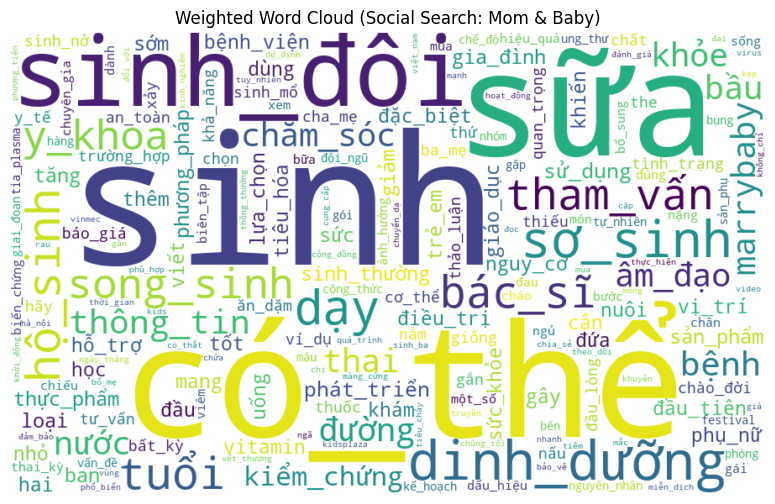

In [10]:
try:
    weights = np.asarray(X.sum(axis=0)).ravel()
    term_weights = {terms[i]: float(weights[i]) for i in range(len(terms))}
    if term_weights:
        font_candidates = [
            "Roboto-Regular.ttf",
            "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf",
        ]
        font_path = next((f for f in font_candidates if os.path.exists(f)), None)
        wc = WordCloud(
            width=900, height=550,
            background_color="white",
            font_path=font_path
        ).generate_from_frequencies(term_weights)

        plt.figure(figsize=(10, 6))
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.title("Weighted Word Cloud (Social Search: Mom & Baby)")
        plt.show()
except Exception as e:
    print("Bỏ qua WordCloud do lỗi:", e)

In [12]:
query = input("Nhập nội dung cần tìm kiếm: ").strip()
exp, res = expand_query(query)
print("✨ Gợi ý mở rộng:", exp)
print(res.to_string(index=False))

✨ Gợi ý mở rộng: ['có_thể', 'trẻ_em', 'nguy_cơ', 'thông_tin', 'bệnh_viện']
                                                            title                                                                                                         source    score   social                            auto_tags                                                                              tags
    Bệnh cúm mùa nên tiêm dịp nào Chỉ định và chống chỉ định tiêm                                                                         https://benhvienphuongdong.vn/tin-tuc/ 0.412059 0.930000 [cúm, vaccine, tiêm, mùa, bệnh, mắc] {'organizational': ['cúm', 'vaccine', 'mùa', 'bệnh', 'mắc'], 'content': ['tiêm']}
Tiêm phòng cúm trước khi mang thai bao lâu để tốt cho cả mẹ và bé https://www.marrybaby.vn/chuan-bi-mang-thai/suc-khoe-va-dinh-duong/tiem-phong-cum-truoc-khi-mang-thai-bao-lau/ 0.392719 0.828333  [cúm, tiêm, thai, phụ, phòng, mang]  {'organizational': ['cúm', 'thai', 'phụ', 'phòng', 'mang'], 'con